### NYC-Taxi Data Analysis


In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, year, month, dayofmonth
import os
import matplotlib.pyplot as plt

#### Section 1: Data Ingestion & Preprocessing

In this section, we load multiple monthly NYC Yellow Taxi Parquet files, clean the data, convert date fields to timestamps, and engineer new time-based features (e.g., hour, day of week). The resulting DataFrame is cached and registered as a temporary SQL view for reuse in later sections.

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [3]:
data_dir = "data"
file_prefix = "yellow_tripdata"

file_paths = []

# Add files for 2020–2024 (all months)
for year in range(2020, 2025):
    for month in range(1, 13):
        path = os.path.join(data_dir, f"{file_prefix}_{year}-{str(month).zfill(2)}.parquet")
        if os.path.exists(path):
            file_paths.append(path)

# Add files for 2025 (only Jan–Mar)
for month in range(1, 4):
    path = os.path.join(data_dir, f"{file_prefix}_2025-{str(month).zfill(2)}.parquet")
    if os.path.exists(path):
        file_paths.append(path)


In [4]:
# 🧾 Load multiple monthly Parquet files
if file_paths:
    df = spark.read.parquet(*file_paths)
else:
    print("No valid files found.")

In [5]:
# Show schema and first few rows
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [6]:
pandas_df = df.limit(3).toPandas()
pandas_df.style.set_table_attributes('style="max-height:300px; overflow-y: auto; display:block;"')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.600000,1,N,229,237,1,10.000000,3.500000,0.500000,3.000000,0.000000,1.000000,18.000000,2.500000,0.000000,0.000000
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.500000,1,N,236,237,1,5.100000,3.500000,0.500000,2.020000,0.000000,1.000000,12.120000,2.500000,0.000000,0.000000
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.600000,1,N,141,141,1,5.100000,3.500000,0.500000,2.000000,0.000000,1.000000,12.100000,2.500000,0.000000,0.000000


In [7]:
# Data Type Conversion (datetime fields)
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

In [8]:
# Basic Cleaning: Filter out invalid entries
df = df.filter(
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("pickup_datetime").isNotNull()) &
    (col("dropoff_datetime").isNotNull())
)

In [9]:
from pyspark.sql.functions import hour, dayofweek, dayofmonth, month, year

df = df.withColumn("hour", hour("pickup_datetime")) \
       .withColumn("day_of_week", dayofweek("pickup_datetime")) \
       .withColumn("day", dayofmonth("pickup_datetime")) \
       .withColumn("month", month("pickup_datetime")) \
       .withColumn("year", year("pickup_datetime"))

In [10]:
# Show schema and sample data
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: tim

In [11]:
# Register as Temp View for SQL Queries
df.createOrReplaceTempView("yellow_taxi_trips")

In [12]:
from pyspark.sql.functions import to_timestamp
# Show basic statistics
# print("Summary statistics (trip_distance, fare_amount):")
df.select("trip_distance", "fare_amount").describe().show()

+-------+-----------------+-----------------+
|summary|    trip_distance|      fare_amount|
+-------+-----------------+-----------------+
|  count|         10413352|         10413352|
|   mean|5.825326975405316|18.52100415697155|
| stddev|532.6486725379589|271.5424317881225|
|    min|             0.01|             0.01|
|    max|        281085.57|        863372.12|
+-------+-----------------+-----------------+



#### Section 2: Time-Series Analysis
We explore trip activity patterns across time. This includes analyzing the distribution of rides by hour, day of the week, and comparing weekday vs. weekend traffic. Visualizations highlight when NYC sees the most taxi activity.

#### Section 3: Geospatial Analysis

This section focuses on spatial trends by identifying high-demand pickup zones. We aggregate pickups by location, merge with NYC taxi zone shapefile data, and create geospatial visualizations showing demand hotspots across the city.

#### Section 4: Advanced Spark SQL Analytics

Using Spark SQL, we run analytical queries to uncover deeper insights: revenue by zone, common pickup-dropoff routes, anomalies in trip data, and average fare metrics. This demonstrates the power of SQL over large datasets with Spark

#### Section 5: Demand Forecasting with Spark MLlib
We apply machine learning to predict hourly taxi demand. After feature engineering and vector assembly, we train regression models using Spark MLlib and evaluate their accuracy. The goal is to forecast demand based on historical trends.

In [13]:
# Convert pickup/dropoff datetime to proper timestamp types (if not already)
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

In [14]:
# Add useful time-based features
df = df.withColumn("hour", hour("pickup_datetime")) \
       .withColumn("dayofweek", dayofweek("pickup_datetime"))

In [15]:
# Filter out records with invalid values
df = df.filter((col("trip_distance") > 0) & (col("fare_amount") > 0))

In [16]:
# Show basic statistics
df.select("trip_distance", "fare_amount").describe().show()

+-------+-----------------+-----------------+
|summary|    trip_distance|      fare_amount|
+-------+-----------------+-----------------+
|  count|         10413352|         10413352|
|   mean|5.825326975405316|18.52100415697155|
| stddev|532.6486725379589|271.5424317881225|
|    min|             0.01|             0.01|
|    max|        281085.57|        863372.12|
+-------+-----------------+-----------------+



In [17]:
# Analyze pickup count by hour
pickup_by_hour = df.groupBy("hour").count().orderBy("hour")
pickup_pd = pickup_by_hour.toPandas()

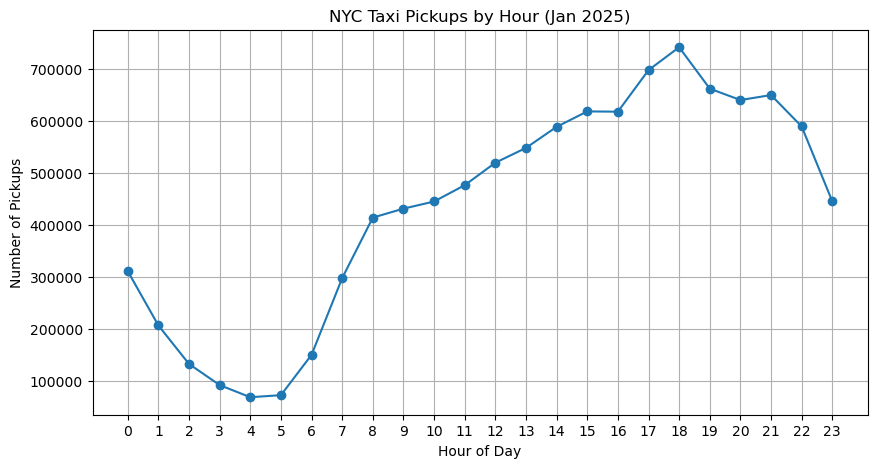

In [18]:
# Plot: Pickups by hour
plt.figure(figsize=(10, 5))
plt.plot(pickup_pd["hour"], pickup_pd["count"], marker='o')
plt.title("NYC Taxi Pickups by Hour (Jan 2025)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

#### Geospatial Analysis with Apache Spark

Objective:
- Identify popular pickup zones.

- Visualize demand hotspots in NYC.

- Optionally, export data for map visualization (e.g., with Folium or GeoPandas).



In [19]:
zone_df = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)

# Join with pickup zone
df = df.join(zone_df, df.PULocationID == zone_df.LocationID, "left") \
       .withColumnRenamed("Borough", "pickup_borough") \
       .withColumnRenamed("Zone", "pickup_zone") \
       .drop("service_zone", "LocationID")


In [20]:
pickup_counts = df.groupBy("pickup_borough", "pickup_zone") \
                  .count() \
                  .orderBy("count", ascending=False)

pickup_counts.show(10, truncate=False)


+--------------+----------------------------+------+
|pickup_borough|pickup_zone                 |count |
+--------------+----------------------------+------+
|Manhattan     |Midtown Center              |487190|
|Manhattan     |Upper East Side South       |473423|
|Manhattan     |Upper East Side North       |437136|
|Queens        |JFK Airport                 |398793|
|Manhattan     |Times Sq/Theatre District   |353394|
|Manhattan     |Penn Station/Madison Sq West|349141|
|Manhattan     |Midtown East                |343886|
|Manhattan     |Lincoln Square East         |316540|
|Manhattan     |Union Sq                    |294043|
|Manhattan     |Murray Hill                 |283852|
+--------------+----------------------------+------+
only showing top 10 rows



In [21]:
pickup_pd = pickup_counts.toPandas()
pickup_pd.to_csv("output/popular_pickup_zones.csv", index=False)


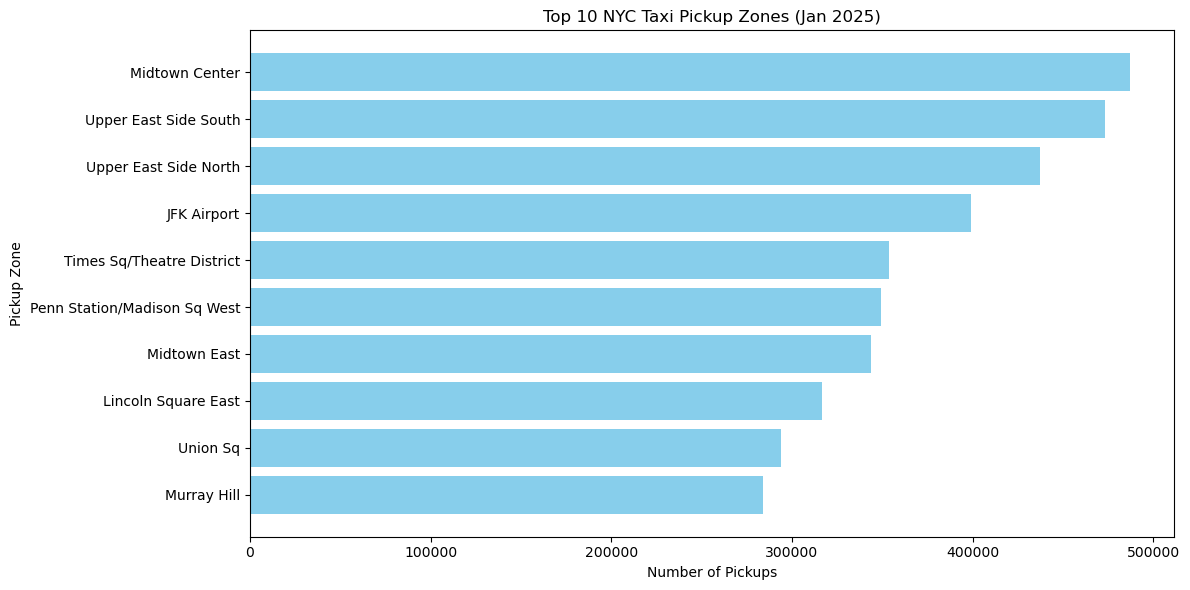

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV you exported from Spark
df2 = pd.read_csv("output/popular_pickup_zones.csv")

# Get top 10 zones
top10 = df2.sort_values(by="count", ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top10["pickup_zone"], top10["count"], color="skyblue")
plt.xlabel("Number of Pickups")
plt.ylabel("Pickup Zone")
plt.title("Top 10 NYC Taxi Pickup Zones (Jan 2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [23]:
!pip install geopandas -q

In [24]:
# Group pickup counts by location
pickup_by_zone = df.groupBy("PULocationID").count()

# Convert to Pandas
pickup_pd = pickup_by_zone.toPandas()


In [25]:
# Load shapefile
gdf = gpd.read_file("data/taxi_zones/taxi_zones.shp")

# Merge on LocationID
merged = gdf.merge(pickup_pd, left_on="LocationID", right_on="PULocationID")


NameError: name 'gpd' is not defined

In [ ]:
plt.figure(figsize=(12, 10))
merged.plot(column="count", cmap="OrRd", legend=True, edgecolor="black")
plt.title("NYC Taxi Pickup Density by Zone (Jan 2025)")
plt.axis("off")
plt.show()
